# Simulation 3
# Statistical Test on SBM Graphs

## Setup
- We use 2-block undirected binary SBM graphs for statistical tests.
- Population 1 and Population 2 have m graphs each.
- Each graph has n vertices.
- $\mathbf{P_1} \in \mathbb{R}^{2 \times 2}$ and $\mathbf{P_2} \in \mathbb{R}^{2 \times 2}$ are probability matrices of Population 1 and Population 2.
$${\begin{matrix}
\mathbf{P_1}=\begin{bmatrix}
b & 0.1 \\
0.1 & 0.5
\end{bmatrix} & \mathbf{P_2} = \begin{bmatrix}
b-eps & 0.1 \\
0.1 & 0.5
\end{bmatrix}
\end{matrix}}
$$
- We use m =10, n =100, b = 0.5, eps = 0.01, to start.

## Procedure
- Generate two populations using the parameters above.
- Visualize the P matrix and one of the graph for each population.
- Use t-test to measure the difference between the populations and draw heatmap.
- Use t-test, Wilcoxon signed rank test and Mann-Whitney U test on 30 graphs and show beeswarm plots of log p-value.
- Plot power of tests for block 11 and type 1 error rate of tests for block 12 and block 22 as b changes.
- Plot power and type 1 error for different m and n.

## Conclusion


### Note for tests:
When doing the statistic tests, we first sum up the m graphs (edges follow Bernoulli distribution) to get one summed graph (edges follow binomial distribution) for each population. We use the edge weights of the summed graphs as inputs of statistical tests, especially only upper trianglar matrix for block 12 and block 22, whole block for block 22.
The scheme shows below.

![scheme](figs/sim3_scheme.png)


In [8]:
# Statistical test on SBM graphs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from graspy.simulations import sbm
from graspy.plot import heatmap
from scipy.stats import ttest_ind, mannwhitneyu,wilcoxon
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
%matplotlib inline

## Step 1
Generate Population 1 and Population2. Visualize P matrices and graphs of them.

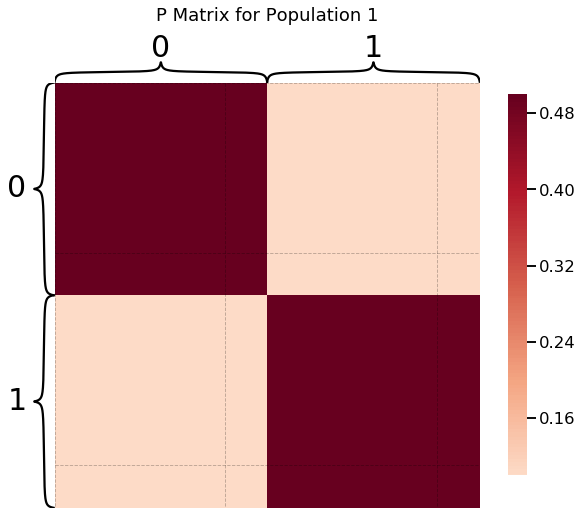

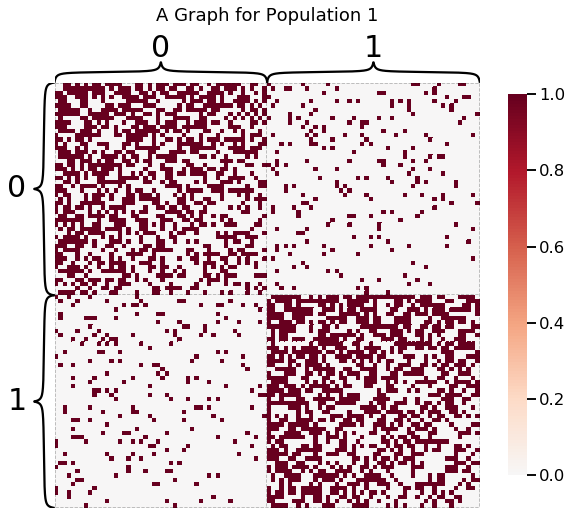

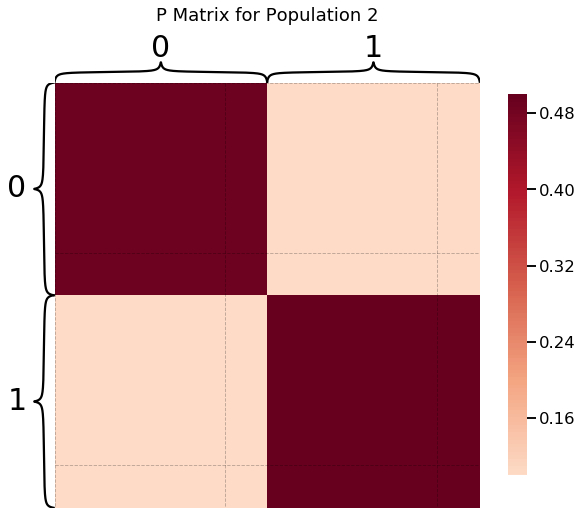

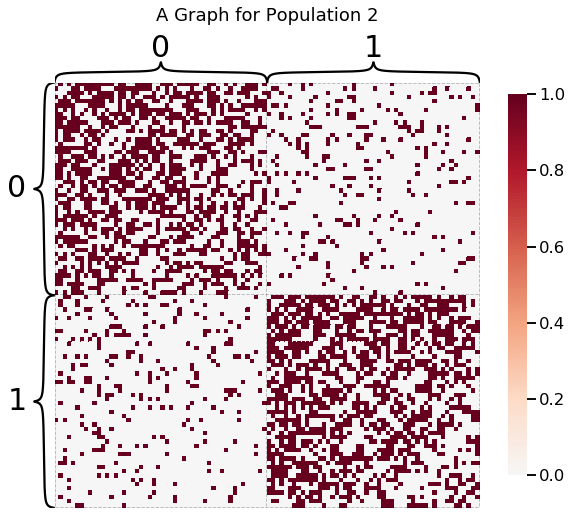

In [2]:
# SBM simulation
np.random.seed(8989)
n = 100
m = 10
b = 0.5
eps = 0.01
n_iter = 30

n_sbm = [int(n/2),int(n/2)]
n_labels = [0] * int(n / 2) + [1] * int(n / 2)
P1 = np.array([[b, 0.1],
             [0.1, 0.5]])
P2 = np.array([[b-eps, 0.1],
              [0.1, 0.5]])

for i in range(m):
    if i==0:
        y1 = sbm(n=n_sbm, p=P1)
        y1 = np.expand_dims(y1,2)
    else:
        y1 = np.append(y1,np.expand_dims(sbm(n=n_sbm, p=P1),2),axis=2)
       
for i in range(m):
    if i==0:
        y2 = sbm(n=n_sbm, p=P2)
        y2 = np.expand_dims(y2,2)
    else:
        y2 = np.append(y2,np.expand_dims(sbm(n=n_sbm, p=P2),2),axis=2)

# plot1
# visualization

heatmap(P1, title='P Matrix for Population 1',inner_hier_labels=[0,1])

heatmap(y1[:,:,0], title='A Graph for Population 1', inner_hier_labels=n_labels)

heatmap(P2, title='P Matrix for Population 2',inner_hier_labels=[0,1])

heatmap(y2[:,:,0], title='A Graph for Population 2', inner_hier_labels=n_labels)


## Step 2
Blockwise two-tailed t-test and heatmap of log p-value.

Block 11 has biggest difference among 4 blocks between the two populations.

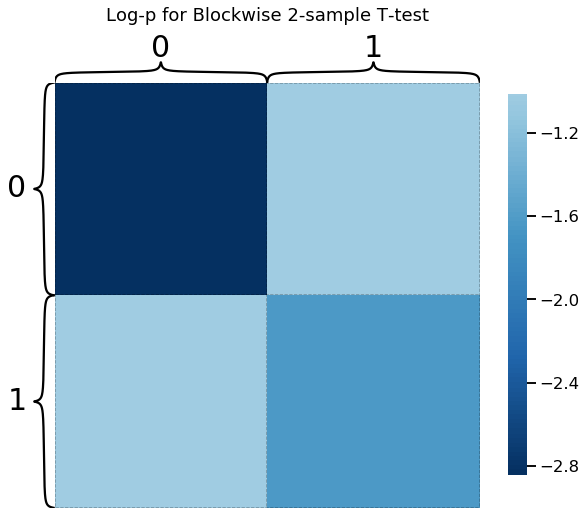

In [5]:
# blockwise t-test 
indices_1 = np.cumsum(n_sbm)
num_blocks = indices_1.shape[0]
p_blocks = np.zeros((num_blocks,num_blocks))
for i in np.arange(num_blocks):
    if i==0:
        start_i = 0
    else:
        start_i = indices_1[i-1]
    end_i = indices_1[i]
    for j in np.arange(i,num_blocks):
        if j==0:
            start_j = 0
        else:
            start_j = indices_1[j-1]
        end_j = indices_1[j]

        block_1 = np.sum(y1[start_i:end_i,start_j:end_j,:],axis=2)
        block_2 = np.sum(y2[start_i:end_i,start_j:end_j,:],axis=2)

        #don't be redundant - only use upper triangle if on a diagonal block
        if i == j:
            idxs = np.triu_indices(n_sbm[i],1)
            binoms_1 = block_1[idxs]    
            binoms_2 = block_2[idxs]
        else:
            binoms_1 = block_1.flatten()      
            binoms_2 = block_2.flatten()
            
        _,p = ttest_ind(binoms_1,binoms_2)
        p_blocks[i,j] = p
        p_blocks[j,i] = p

b00 = p_blocks[0,0]*np.ones((n_sbm[0],n_sbm[0]))
b01 = p_blocks[0,1]*np.ones((n_sbm[0],n_sbm[1]))
b10 = p_blocks[1,0]*np.ones((n_sbm[1],n_sbm[0]))
b11 = p_blocks[1,1]*np.ones((n_sbm[1],n_sbm[1]))
top = np.concatenate((b00,b01),axis=1)
bottom = np.concatenate((b10,b11),axis=1)
output = np.concatenate((top,bottom),axis=0)

plot = heatmap(output,inner_hier_labels=n_labels,
	title ='Log-p for Blockwise 2-sample T-test',
	transform='log')

## Step 3
T-test, Wilcoxon signed rank test and Mann-Whitney U test on 30 graphs.

T-test is used to determine if there is a significant difference between the means of two groups, which should follow normal distributions. Wilcoxon signed rank test and Mann-Whitney U test (also called the Mann–Whitney–Wilcoxon (MWW), Wilcoxon rank sum test) are both non-parametric statistical hypothesis tests used to compare two samples, while Wilcoxon signed test for matched samples and Man-Whitney U test for independent samples. All these tests we used are two-sided.

Note: The lines in figures represent the threshold of p-value.

Line: y = log(0.05)


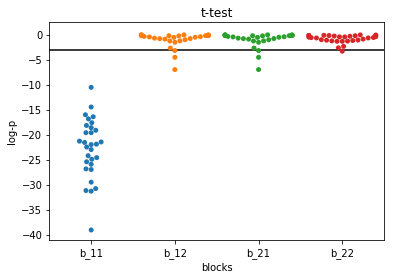

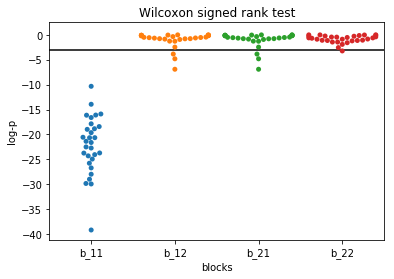

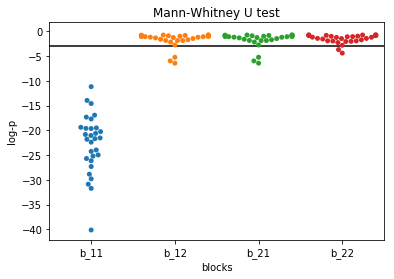

In [14]:
# t-test & Wilcoxon signed rank test & Mann-Whitney U test
indices_1 = np.cumsum(n_sbm)
num_blocks = indices_1.shape[0]
pt_blocks = np.zeros((num_blocks,num_blocks))
pw_blocks = np.zeros((num_blocks,num_blocks))
pm_blocks = np.zeros((num_blocks,num_blocks))
pt_value = pd.DataFrame(columns=["blocks","log-p"])
pw_value = pd.DataFrame(columns=["blocks","log-p"])
pm_value = pd.DataFrame(columns=["blocks","log-p"])

for k in range(30):
    for i in range(m):
        if i==0:
            y1 = sbm(n=n_sbm, p=P1)
            y1 = np.expand_dims(y1,2)
        else:
            y1 = np.append(y1,np.expand_dims(sbm(n=n_sbm, p=P1),2),axis=2)
       
    for i in range(m):
        if i==0:
            y2 = sbm(n=n_sbm, p=P2)
            y2 = np.expand_dims(y2,2)
        else:
            y2 = np.append(y2,np.expand_dims(sbm(n=n_sbm, p=P2),2),axis=2)
            
    for i in np.arange(num_blocks):
        if i==0:
            start_i = 0
        else:
            start_i = indices_1[i-1]
        end_i = indices_1[i]
        for j in np.arange(i,num_blocks):
            if j==0:
                start_j = 0
            else:
                start_j = indices_1[j-1]
            end_j = indices_1[j]

            block_1 = np.sum(y1[start_i:end_i,start_j:end_j,:],axis=2)
            block_2 = np.sum(y2[start_i:end_i,start_j:end_j,:],axis=2)

            #don't be redundant - only use upper triangle if on a diagonal block
            if i == j:
                idxs = np.triu_indices(n_sbm[i],1)
                binoms_1 = block_1[idxs]
                binoms_2 = block_2[idxs]
            else:
                binoms_1 = block_1.flatten()
                binoms_2 = block_2.flatten()

            # t-test
            _,p = ttest_ind(binoms_1,binoms_2)
            pt_blocks[i,j] = p
            pt_blocks[j,i] = p
            
            # Wilcoxon signed rank test
            _,p = wilcoxon(binoms_1,binoms_2)
            # _,p = wilcoxon(binoms_1,binoms_2,zero_method="pratt")
            pw_blocks[i,j] = p
            pw_blocks[j,i] = p
            
            # Mann-Whitney U test
            _,p = mannwhitneyu(binoms_1,binoms_2)
            pm_blocks[i,j] = p
            pm_blocks[j,i] = p
    
    pt_value = pt_value.append(pd.DataFrame({"blocks":["b_11"],"log-p":[np.log(pt_blocks[0,0])]}),ignore_index=True,sort=False)
    pt_value = pt_value.append(pd.DataFrame({"blocks":["b_12"],"log-p":[np.log(pt_blocks[0,1])]}),ignore_index=True,sort=False)
    pt_value = pt_value.append(pd.DataFrame({"blocks":["b_21"],"log-p":[np.log(pt_blocks[1,0])]}),ignore_index=True,sort=False)
    pt_value = pt_value.append(pd.DataFrame({"blocks":["b_22"],"log-p":[np.log(pt_blocks[1,1])]}),ignore_index=True,sort=False)
    
    pw_value = pw_value.append(pd.DataFrame({"blocks":["b_11"],"log-p":[np.log(pw_blocks[0,0])]}),ignore_index=True,sort=False)
    pw_value = pw_value.append(pd.DataFrame({"blocks":["b_12"],"log-p":[np.log(pw_blocks[0,1])]}),ignore_index=True,sort=False)
    pw_value = pw_value.append(pd.DataFrame({"blocks":["b_21"],"log-p":[np.log(pw_blocks[1,0])]}),ignore_index=True,sort=False)
    pw_value = pw_value.append(pd.DataFrame({"blocks":["b_22"],"log-p":[np.log(pw_blocks[1,1])]}),ignore_index=True,sort=False)
    
    pm_value = pm_value.append(pd.DataFrame({"blocks":["b_11"],"log-p":[np.log(pm_blocks[0,0])]}),ignore_index=True,sort=False)
    pm_value = pm_value.append(pd.DataFrame({"blocks":["b_12"],"log-p":[np.log(pm_blocks[0,1])]}),ignore_index=True,sort=False)
    pm_value = pm_value.append(pd.DataFrame({"blocks":["b_21"],"log-p":[np.log(pm_blocks[1,0])]}),ignore_index=True,sort=False)
    pm_value = pm_value.append(pd.DataFrame({"blocks":["b_22"],"log-p":[np.log(pm_blocks[1,1])]}),ignore_index=True,sort=False)
    
plt.figure()
plt.title("t-test")
plt.axhline(y=np.log(0.05),color = 'k')
sns.swarmplot(x="blocks",y="log-p",data=pt_value)

plt.figure()
plt.title("Wilcoxon signed rank test")
plt.axhline(y=np.log(0.05),color = 'k')
sns.swarmplot(x="blocks",y="log-p",data=pw_value)

plt.figure()
plt.title("Mann-Whitney U test")
plt.axhline(y=np.log(0.05),color = 'k')
sns.swarmplot(x="blocks",y="log-p",data=pm_value)
print("Line: y = log(0.05)")

## Step 4
Plot power and type 1 error rate when b changes.

Power (type 1 error rate) is defined as the proportion of positive (negative) results among all experiments. As for P matrices we use, the proportion of p-values less than threshold (0.05 in this case) equals to power in block 11 and type 1 error rate in block 12 and block 22.

All these tests have approximately equal power and type 1 error rate.

In [9]:
# calculate p value
n =100
n_sbm = [int(n/2),int(n/2)]
eps=0.01
m = 10
n_b = int((1-eps*2)/0.01+1)
n_iter = 200
indices_1 = np.cumsum(n_sbm)
num_blocks = indices_1.shape[0]

pt_b_value = np.zeros((num_blocks,num_blocks,n_iter,n_b))
pw_b_value = np.zeros((num_blocks,num_blocks,n_iter,n_b))
pm_b_value = np.zeros((num_blocks,num_blocks,n_iter,n_b))

for rank_b in range(n_b):
    b = eps + 0.01 * rank_b
    
    # P matrix for different b
    P1 = np.array([[b, 0.1],
                 [0.1, 0.5]])
    P2 = np.array([[b-eps, 0.1],
                    [0.1, 0.5]])
    '''
    if b<0.5:
        P2 = np.array([[b+eps, 0.1],
                        [0.1, 0.5]]) 
    else:
        P2 = np.array([[b-eps, 0.1],
                        [0.1, 0.5]])
    '''
    for k in range(n_iter):
        
        # generate sbm matrix for population 1 and population 2
        for i in range(m):
            if i==0:
                y1 = sbm(n=n_sbm, p=P1)
                y1 = np.expand_dims(y1,2)
            else:
                y1 = np.append(y1,np.expand_dims(sbm(n=n_sbm, p=P1),2),axis=2)

        for i in range(m):
            if i==0:
                y2 = sbm(n=n_sbm, p=P2)
                y2 = np.expand_dims(y2,2)
            else:
                y2 = np.append(y2,np.expand_dims(sbm(n=n_sbm, p=P2),2),axis=2)

        # calculate P value of 3 blocks        
        for i in np.arange(num_blocks):
            
            if i==0:
                start_i = 0
            else:
                start_i = indices_1[i-1]
            end_i = indices_1[i]
            
            for j in np.arange(i,num_blocks):
                if j==0:
                    start_j = 0
                else:
                    start_j = indices_1[j-1]
                end_j = indices_1[j]

                # single block for population 1 and population 2
                block_1 = np.sum(y1[start_i:end_i,start_j:end_j,:],axis=2)
                block_2 = np.sum(y2[start_i:end_i,start_j:end_j,:],axis=2)

                #don't be redundant - only use upper triangle if on a diagonal block
                # get data set used for test
                if i == j:
                    idxs = np.triu_indices(n_sbm[i],1)
                    binoms_1 = block_1[idxs]
                    binoms_2 = block_2[idxs]
                else:
                    binoms_1 = block_1.flatten()
                    binoms_2 = block_2.flatten()

                # t-test    
                _,pt = ttest_ind(binoms_1,binoms_2)
                pt_b_value[i,j,k,rank_b]=pt
                pt_b_value[i,j,k,rank_b]=pt
                
                # Wilcoxon signed rank test
                _,pw = wilcoxon(binoms_1,binoms_2)
                pw_b_value[i,j,k,rank_b]=pw
                pw_b_value[i,j,k,rank_b]=pw
                
                # Mann-Whitney U test
                if math.isnan(pw): # the 2 populations are the same
                    pm = float('nan')
                else:
                    _,pm = mannwhitneyu(binoms_1,binoms_2,alternative="two-sided")
                pm_b_value[i,j,k,rank_b]=pm
                pm_b_value[i,j,k,rank_b]=pm

In [10]:
# calculate power and type 1 error
# using the results got in above cell
alpha = 0.05
powert_b11 = np.zeros(n_b)
errort_b12 = np.zeros(n_b)
errort_b22 = np.zeros(n_b)

powerw_b11 = np.zeros(n_b)
errorw_b12 = np.zeros(n_b)
errorw_b22 = np.zeros(n_b)

powerm_b11 = np.zeros(n_b)
errorm_b12 = np.zeros(n_b)
errorm_b22 = np.zeros(n_b)

for rank_b in range(n_b):
    # calculate power for block_11 
    powert_b11[rank_b] = np.count_nonzero(pt_b_value[0,0,:,rank_b]<alpha)/n_iter
    powerw_b11[rank_b] = np.count_nonzero(pw_b_value[0,0,:,rank_b]<alpha)/n_iter
    powerm_b11[rank_b] = np.count_nonzero(pm_b_value[0,0,:,rank_b]<alpha)/n_iter
    
    # calculate type1 error for block_12 and block_22
    errort_b12[rank_b] = np.count_nonzero(pt_b_value[0,1,:,rank_b]<alpha)/n_iter
    errorw_b12[rank_b] = np.count_nonzero(pw_b_value[0,1,:,rank_b]<alpha)/n_iter
    errorm_b12[rank_b] = np.count_nonzero(pm_b_value[0,1,:,rank_b]<alpha)/n_iter
    
    errort_b22[rank_b] = np.count_nonzero(pt_b_value[1,1,:,rank_b]<alpha)/n_iter
    errorw_b22[rank_b] = np.count_nonzero(pw_b_value[1,1,:,rank_b]<alpha)/n_iter
    errorm_b22[rank_b] = np.count_nonzero(pm_b_value[1,1,:,rank_b]<alpha)/n_iter

Text(0.5, 1.0, 'block 22, n=100, m=10, n_iter=200, eps = 0.01')

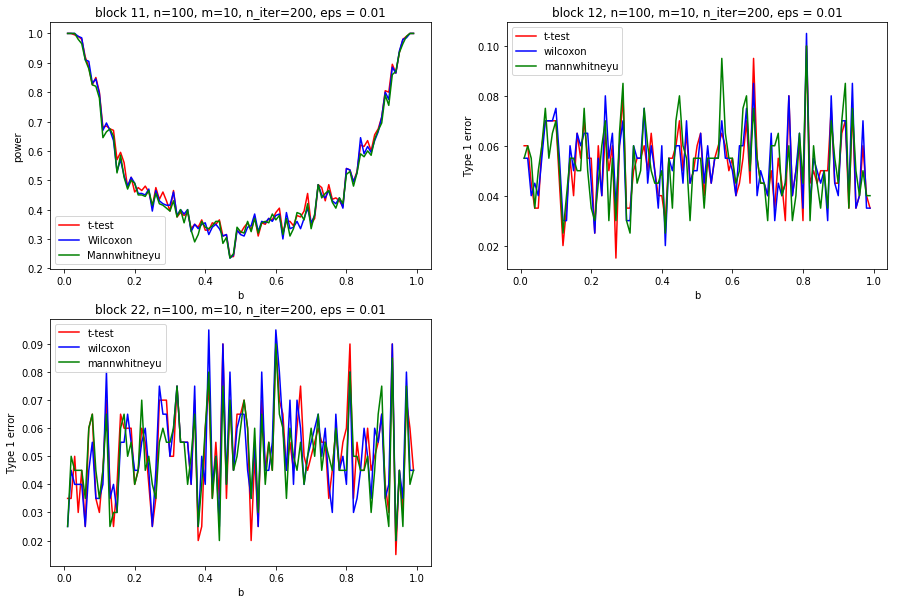

In [11]:
# visualization
# plot power and type 1 error
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),powert_b11,'r', label='t-test')
plt.xlabel("b")
plt.ylabel("power")
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),powerw_b11,'b', label='Wilcoxon')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),powerm_b11,'g', label='Mannwhitneyu')
plt.legend()
plt.title("block 11, n="+str(n)+", m="+str(m)+", n_iter="+str(n_iter)+", eps = "+str(eps))

plt.subplot(222)
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errort_b12,'r', label='t-test')
plt.xlabel("b")
plt.ylabel("Type 1 error")
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorw_b12,'b', label='wilcoxon')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorm_b12,'g', label='mannwhitneyu')
plt.legend()
plt.title("block 12, n="+str(n)+", m="+str(m)+", n_iter="+str(n_iter)+", eps = "+str(eps))

plt.subplot(223)
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errort_b22,'r', label='t-test')
plt.xlabel("b")
plt.ylabel("Type 1 error")
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorw_b22,'b', label='wilcoxon')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorm_b22,'g', label='mannwhitneyu')
plt.legend()
plt.title("block 22, n="+str(n)+", m="+str(m)+", n_iter="+str(n_iter)+", eps = "+str(eps))

## Step 5
Change n and m and compare the results.

We take 4 conditions into consideration: small m, small n; small m, big n; big m, small n; big m, big n.

When m and n are both small, the power and type 1 error are extremely low, while the power of test is a bit higher than Wilcoxon's and Mann-Whitney's. When m becomes bigger, the difference between them decreases. When n is big enough, representing the large quantity of samples, all these tests will have reasonable approximately power and type 1 error.

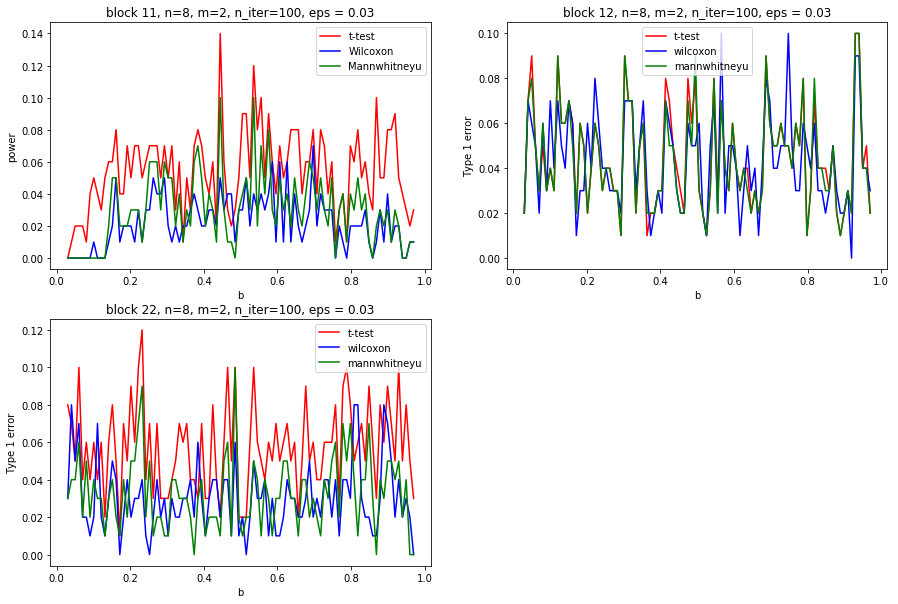

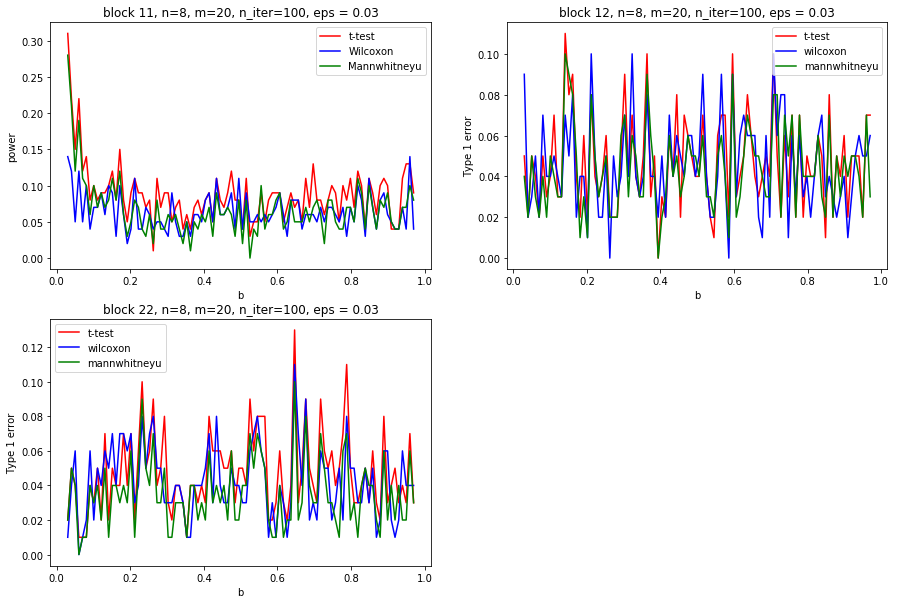

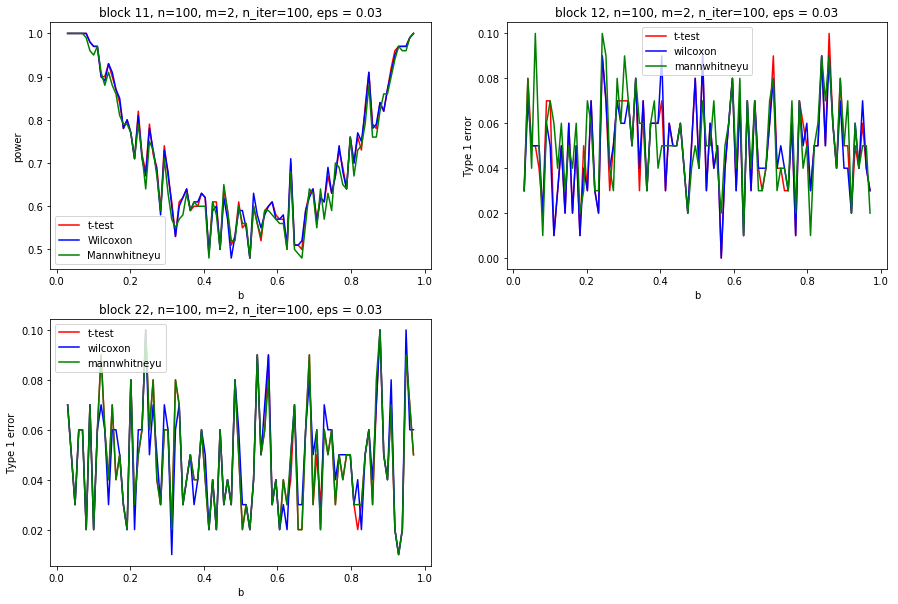

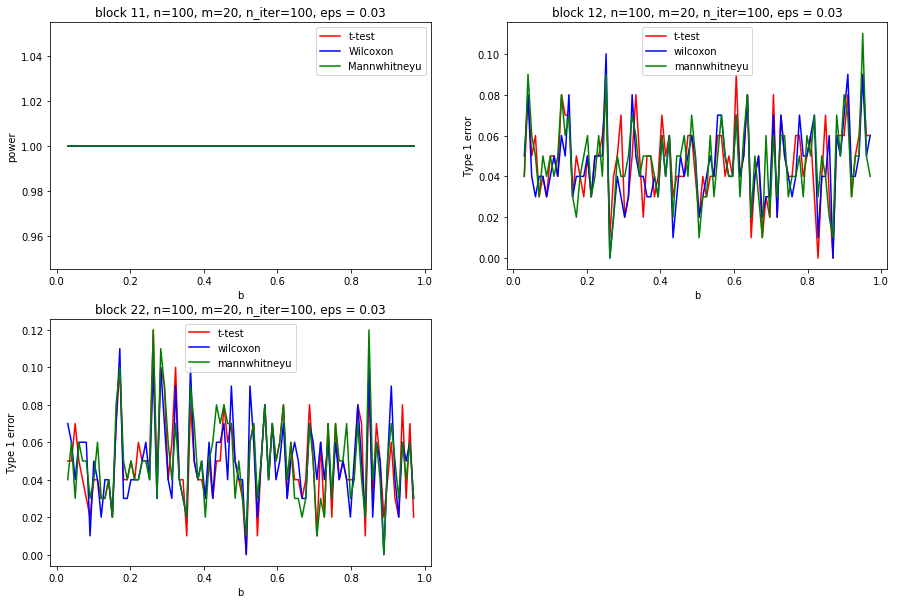

In [16]:
# change n and m
N = [8, 100]
M = [2, 20]
eps=0.03
n_b = int((1-eps*2)/0.01+1)
n_iter = 100

pt_b_value = np.zeros((num_blocks,num_blocks,n_iter,n_b))
pw_b_value = np.zeros((num_blocks,num_blocks,n_iter,n_b))
pm_b_value = np.zeros((num_blocks,num_blocks,n_iter,n_b))

for n in N:
    n_sbm = [int(n/2),int(n/2)]
    indices_1 = np.cumsum(n_sbm)
    num_blocks = indices_1.shape[0]
    for m in M:
        for rank_b in range(n_b):
            b = eps + 0.01 * rank_b

            # P matrix for different b
            P1 = np.array([[b, 0.1],
                         [0.1, 0.5]])
            P2 = np.array([[b-eps, 0.1],
                            [0.1, 0.5]])
            '''
            if b<0.5:
                P2 = np.array([[b+eps, 0.1],
                                [0.1, 0.5]]) 
            else:
                P2 = np.array([[b-eps, 0.1],
                                [0.1, 0.5]])
            '''
            for k in range(n_iter):

                # generate sbm matrix for population 1 and population 2
                for i in range(m):
                    if i==0:
                        y1 = sbm(n=n_sbm, p=P1)
                        y1 = np.expand_dims(y1,2)
                    else:
                        y1 = np.append(y1,np.expand_dims(sbm(n=n_sbm, p=P1),2),axis=2)

                for i in range(m):
                    if i==0:
                        y2 = sbm(n=n_sbm, p=P2)
                        y2 = np.expand_dims(y2,2)
                    else:
                        y2 = np.append(y2,np.expand_dims(sbm(n=n_sbm, p=P2),2),axis=2)

                # calculate P value of 3 blocks        
                for i in np.arange(num_blocks):

                    if i==0:
                        start_i = 0
                    else:
                        start_i = indices_1[i-1]
                    end_i = indices_1[i]

                    for j in np.arange(i,num_blocks):
                        if j==0:
                            start_j = 0
                        else:
                            start_j = indices_1[j-1]
                        end_j = indices_1[j]

                        # single block for population 1 and population 2
                        block_1 = np.sum(y1[start_i:end_i,start_j:end_j,:],axis=2)
                        block_2 = np.sum(y2[start_i:end_i,start_j:end_j,:],axis=2)

                        #don't be redundant - only use upper triangle if on a diagonal block
                        # get data set used for test
                        if i == j:
                            idxs = np.triu_indices(n_sbm[i],1)
                            binoms_1 = block_1[idxs]
                            binoms_2 = block_2[idxs]
                        else:
                            binoms_1 = block_1.flatten()
                            binoms_2 = block_2.flatten()

                        # t-test    
                        _,pt = ttest_ind(binoms_1,binoms_2)
                        pt_b_value[i,j,k,rank_b]=pt
                        pt_b_value[i,j,k,rank_b]=pt

                        # Wilcoxon signed rank test
                        _,pw = wilcoxon(binoms_1,binoms_2)
                        pw_b_value[i,j,k,rank_b]=pw
                        pw_b_value[i,j,k,rank_b]=pw

                        # Mann-Whitney U test
                        if math.isnan(pw): # the 2 populations are the same. Without this, mannwhitneyu will raise ValueError.
                            pm = float('nan') 
                        else:
                            _,pm = mannwhitneyu(binoms_1,binoms_2,alternative="two-sided")
                        pm_b_value[i,j,k,rank_b]=pm
                        pm_b_value[i,j,k,rank_b]=pm

        # calculate power and type 1 error
        # using the results got in above cell
        alpha = 0.05
        powert_b11 = np.zeros(n_b)
        errort_b12 = np.zeros(n_b)
        errort_b22 = np.zeros(n_b)
        powerw_b11 = np.zeros(n_b)
        errorw_b12 = np.zeros(n_b)
        errorw_b22 = np.zeros(n_b)
        powerm_b11 = np.zeros(n_b)
        errorm_b12 = np.zeros(n_b)
        errorm_b22 = np.zeros(n_b)

        for rank_b in range(n_b):
            # calculate power for block_11 
            powert_b11[rank_b] = np.count_nonzero(pt_b_value[0,0,:,rank_b]<alpha)/n_iter
            powerw_b11[rank_b] = np.count_nonzero(pw_b_value[0,0,:,rank_b]<alpha)/n_iter
            powerm_b11[rank_b] = np.count_nonzero(pm_b_value[0,0,:,rank_b]<alpha)/n_iter

            # calculate type1 error for block_12 and block_22
            errort_b12[rank_b] = np.count_nonzero(pt_b_value[0,1,:,rank_b]<alpha)/n_iter
            errorw_b12[rank_b] = np.count_nonzero(pw_b_value[0,1,:,rank_b]<alpha)/n_iter
            errorm_b12[rank_b] = np.count_nonzero(pm_b_value[0,1,:,rank_b]<alpha)/n_iter

            errort_b22[rank_b] = np.count_nonzero(pt_b_value[1,1,:,rank_b]<alpha)/n_iter
            errorw_b22[rank_b] = np.count_nonzero(pw_b_value[1,1,:,rank_b]<alpha)/n_iter
            errorm_b22[rank_b] = np.count_nonzero(pm_b_value[1,1,:,rank_b]<alpha)/n_iter

        # visualization
        plt.figure(figsize=(15,10))
        plt.subplot(221)
        plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),powert_b11,'r', label='t-test')
        plt.xlabel("b")
        plt.ylabel("power")
        plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),powerw_b11,'b', label='Wilcoxon')
        plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),powerm_b11,'g', label='Mannwhitneyu')
        plt.legend()
        plt.title("block 11, n="+str(n)+", m="+str(m)+", n_iter="+str(n_iter)+", eps = "+str(eps))

        plt.subplot(222)
        plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errort_b12,'r', label='t-test')
        plt.xlabel("b")
        plt.ylabel("Type 1 error")
        plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorw_b12,'b', label='wilcoxon')
        plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorm_b12,'g', label='mannwhitneyu')
        plt.legend()
        plt.title("block 12, n="+str(n)+", m="+str(m)+", n_iter="+str(n_iter)+", eps = "+str(eps))

        plt.subplot(223)
        plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errort_b22,'r', label='t-test')
        plt.xlabel("b")
        plt.ylabel("Type 1 error")
        plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorw_b22,'b', label='wilcoxon')
        plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorm_b22,'g', label='mannwhitneyu')
        plt.legend()
        plt.title("block 22, n="+str(n)+", m="+str(m)+", n_iter="+str(n_iter)+", eps = "+str(eps))